**Importing libraries: visualization, text analysis and classifiers**



In [108]:
import nltk  
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [109]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.graph_objs as go

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

import nltk
import string
import nltk.corpus
import nltk.stem.snowball
from nltk.corpus import wordnet
# Get default English stopwords and extend with punctuation
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(string.punctuation)
stopwords.append('')

from wordcloud import WordCloud, ImageColorGenerator


In [50]:
from google.colab import files
uploaded=files.upload()

Saving cleaned_hm.csv to cleaned_hm (3).csv


In [110]:
happy = pd.read_csv('cleaned_hm.csv')
happy.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection


In [0]:
from google.colab import files
uploaded=files.upload()

Saving demographic.csv to demographic.csv


In [111]:
demographic  = pd.read_csv('demographic.csv')
demographic .head()

,wid,age,country,gender,marital,parenthood
0,1,37.0,USA,m,married,y
1,2,29.0,IND,m,married,y
2,3,25,IND,m,single,n
3,4,32,USA,m,married,y
4,5,29,USA,m,married,y


**Dataset size and description**

In [112]:
happy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100535 entries, 0 to 100534
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   hmid                   100535 non-null  int64 
 1   wid                    100535 non-null  int64 
 2   reflection_period      100535 non-null  object
 3   original_hm            100535 non-null  object
 4   cleaned_hm             100535 non-null  object
 5   modified               100535 non-null  bool  
 6   num_sentence           100535 non-null  int64 
 7   ground_truth_category  14125 non-null   object
 8   predicted_category     100535 non-null  object
dtypes: bool(1), int64(3), object(5)
memory usage: 6.2+ MB


In [113]:
demographic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10844 entries, 0 to 10843
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   wid         10844 non-null  int64 
 1   age         10809 non-null  object
 2   country     10771 non-null  object
 3   gender      10812 non-null  object
 4   marital     10787 non-null  object
 5   parenthood  10813 non-null  object
dtypes: int64(1), object(5)
memory usage: 508.4+ KB


**Cleaning Demographic dataset | Performed only once**

In [0]:
# RUN THIS FUNCTION ONLY ONCE AND SAVE demographic_cleaned.csv IN YOUR ACTIVE DIRECTORY
# clean_string function to remove text string but keep number string, float and integer
# I ran the clean_string function below only once and saved the cleaned dataframe as demographic_cleaned.csv
# For all subsequent analysis, I then import demographic_cleaned.csv directly in order to avoid cleaning data each time.

def clean_string(df, column):
   for i in range(0,len(df)):
       if type(df[column][i])==str:
           df[column][i] = df[column][i].split('.')[0]
           if df[column][i].isdigit()==False:
               df[column][i]=50
   return df
demographic = clean_string(demographic, 'age')

demographic.head(2)
demographic.to_csv("demographic_cleaned.csv", index=False)


**Merging datasets**

In [114]:
happy = pd.merge(happy, demographic, on='wid', validate = 'm:1')
#pd.pivot_table(happy, values='hmid',index='reflection_period', aggfunc='count')
happy.head(3)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,age,country,gender,marital,parenthood
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection,35,USA,m,single,n
1,27873,2053,24h,I played a new game that was fun and got to en...,I played a new game that was fun and got to en...,True,1,NaN,leisure,35,USA,m,single,n
2,28073,2053,24h,I listened to some music and heard an entire a...,I listened to some music and heard an entire a...,True,1,NaN,leisure,35,USA,m,single,n


In [0]:
# #Dataset reduction during development/testing stages
# happy = happy[1:50000] #Smaller dataset to test code before final run with full dataset
# demographic = demographic[1:5000] # Could also use .sample(frac=0.10)

**Data preprocessing steps**

**Text length (count of words)**

In [116]:
#Create additional column with length of cleaned_hm
happy['length'] = happy['cleaned_hm'].apply(lambda x: len(x.split()))
#happy[happy['reflection_period']== '24h'].head(2)
happy.head(2)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,age,country,gender,marital,parenthood,length
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection,35,USA,m,single,n,14
1,27873,2053,24h,I played a new game that was fun and got to en...,I played a new game that was fun and got to en...,True,1,NaN,leisure,35,USA,m,single,n,16


In [117]:
# Switching relection_period column to the end in order to keep all features to analyse together
cols = happy.columns.tolist()
cols=['hmid',
 'wid',
 'cleaned_hm',
 'num_sentence',
 'predicted_category',
 'length',
 'age',
 'country',
 'gender',
 'marital',
 'parenthood',
 'reflection_period']
happy = happy[cols]
happy.head(2)

,hmid,wid,cleaned_hm,num_sentence,predicted_category,length,age,country,gender,marital,parenthood,reflection_period
0,27673,2053,I went on a successful date with someone I fel...,1,affection,14,35,USA,m,single,n,24h
1,27873,2053,I played a new game that was fun and got to en...,1,leisure,16,35,USA,m,single,n,24h



**Converting categorical data to numerical values**

**1. reflection_period**

In [0]:
# reflection_period: replace 3m by 1, 24h by 0
happy.loc[happy['reflection_period']=='24h', 'reflection_period']=0
happy.loc[happy['reflection_period']=='3m', 'reflection_period']=1
happy.rename(columns={'3m': '3m or 24h'}, inplace=True)

**2. marital status**

In [119]:
pd.pivot_table(happy, values='hmid',index='marital', aggfunc='count')

,hmid
marital,
divorced,3803
married,41343
separated,649
single,54106
widowed,477


In [0]:
# Replace marital with numerical values: married=1 or not-married=0
happy.loc[happy['marital']=='single', 'marital']=0
happy.loc[happy['marital']=='married', 'marital']=1
happy.loc[happy['marital']=='separated', 'marital']=0
happy.loc[happy['marital']=='divorced', 'marital']=0
happy.loc[happy['marital']=='widowed', 'marital']=0
#happy[(happy['marital']!=1) & (happy['marital']!=0)]

In [0]:
happy['marital'].dropna(inplace=True) # drops rows with missing marital values

In [122]:
pd.pivot_table(happy, values='hmid',index='marital', aggfunc='count')

,hmid
marital,
0,59035
1,41343


**3.gender**

In [123]:
pd.pivot_table(happy, values='hmid',index='gender', aggfunc='count')

,hmid
gender,
f,42069
m,57690
o,697


In [0]:
# Replace gender with numerical values
happy.loc[happy['gender']=='m', 'gender']=0
happy.loc[happy['gender']=='f', 'gender']=1
happy.loc[happy['gender']=='o', 'gender']=0

**4.predicted_category**

In [125]:
pd.pivot_table(happy, values='hmid',index='predicted_category', aggfunc='count')

,hmid
predicted_category,
achievement,33993
affection,34168
bonding,10727
enjoy_the_moment,11144
exercise,1202
leisure,7458
nature,1843


In [126]:
# Replace predicted_category by numerical values aligned to 360 Living categories
happy.loc[happy['predicted_category']=='achievement', 'predicted_category']=3
happy.loc[happy['predicted_category']=='affection', 'predicted_category']=6
happy.loc[happy['predicted_category']=='bonding', 'predicted_category']=5
happy.loc[happy['predicted_category']=='enjoy_the_moment', 'predicted_category']=2
happy.loc[happy['predicted_category']=='exercise', 'predicted_category']=1
happy.loc[happy['predicted_category']=='leisure', 'predicted_category']=7
happy.loc[happy['predicted_category']=='nature', 'predicted_category']=4
happy.head(20)

,hmid,wid,cleaned_hm,num_sentence,predicted_category,length,age,country,gender,marital,parenthood,reflection_period
0,27673,2053,I went on a successful date with someone I fel...,1,6,14,35,USA,0,0,n,0
1,27873,2053,I played a new game that was fun and got to en...,1,7,16,35,USA,0,0,n,0
2,28073,2053,I listened to some music and heard an entire a...,1,7,17,35,USA,0,0,n,0
3,33522,2053,Went to see a movie with my friend,1,5,8,35,USA,0,0,n,0
4,34522,2053,"Played guitar, learning a song on it",1,7,7,35,USA,0,0,n,0
5,35522,2053,Talked to my romantic prospect,1,6,5,35,USA,0,0,n,0
6,40281,2053,I played a game for about half an hour.,1,7,9,35,USA,0,0,n,0
7,40381,2053,I discovered another album I hadn't heard by a...,1,3,14,35,USA,0,0,n,0
8,40481,2053,I talked to the girl I'm dating about some int...,1,6,11,35,USA,0,0,n,0
9,27674,2,I was happy when my son got 90% marks in his e...,1,6,12,29.0,IND,0,1,y,0


**5.parenthood**

In [127]:
pd.pivot_table(happy, values='hmid',index='parenthood', aggfunc='count')

,hmid
parenthood,
n,60937
y,39520


In [0]:
# Replace parenthood
happy.loc[happy['parenthood']=='n', 'parenthood']=0
happy.loc[happy['parenthood']=='y', 'parenthood']=1

**6. Country**

In [129]:
pd.pivot_table(happy, values='hmid',index='country', dropna=True,aggfunc='count').sort_values('hmid', ascending=False).head(8)

,hmid
country,
USA,79063
IND,16729
VEN,588
CAN,555
GBR,364
PHL,279
MEX,150
VNM,126


In [130]:
# Replace country by numerical values only for top5 countries, all others are 5
happy.loc[happy['country']=='USA', 'country']=1
happy.loc[happy['country']=='IND', 'country']=0
happy.loc[happy['country']=='VEN', 'country']=0
happy.loc[happy['country']=='CAN', 'country']=0
happy.loc[happy['country']=='GBR', 'country']=0
pd.pivot_table(happy, values='hmid',index='country', dropna=True,aggfunc='count').sort_values('hmid', ascending=False).head(8)

,hmid
country,
1,79063
0,18236
PHL,279
MEX,150
VNM,126
BRA,123
AUS,117
MKD,104


In [131]:
def convert_string(x):
    if isinstance(x, str) == True:
        return 0
    else: return x
happy['country']=happy['country'].apply(lambda x: convert_string(x))
pd.pivot_table(happy, values='hmid',index='country', dropna=True,aggfunc='count').sort_values('hmid', ascending=False).head(8)

,hmid
country,
1.0,79063
0.0,21269


**Data Preprocessing steps for Text Data**

In [0]:
from bs4 import BeautifulSoup
import string
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

**Remove Punctuation**

In [0]:
def removePunctuation(text):
  clean = "".join([c for c in text if c not in string.punctuation])
  return clean

In [0]:
happy["cleaned_hm"] = happy["cleaned_hm"].apply(lambda x: removePunctuation(x))

**Remove stop words**

In [0]:
def removePStopWords(text):
  clean = [c for c in text if c not in stopwords]
  return clean

In [0]:
happy["cleaned_hm"] = happy["cleaned_hm"].apply(lambda x: removePStopWords(x))

**Lemitizer**

In [0]:
lemitizer = WordNetLemmatizer()

def wordLimitizing(text):
  clean = [lemitizer.lemmatize(i) for i in text]
  return clean

In [0]:
happy["cleaned_hm"] = happy["cleaned_hm"].apply(lambda x: wordLimitizing(x))

In [138]:
happy["cleaned_hm"]

0         [I,  , w, e, n,  , n,  ,  , u, c, c, e, f, u, ...
1         [I,  , p, l, e,  ,  , n, e, w,  , g, e,  , h, ...
2         [I,  , l, e, n, e,  ,  , e,  , u, c,  , n,  , ...
3         [W, e, n,  ,  , e, e,  ,  , v, e,  , w, h,  , ...
4         [P, l, e,  , g, u, r,  , l, e, r, n, n, g,  , ...
                                ...                        
100530    [W,  , l,  , I,  , w,  ,  , g, r, e,  , e, p, ...
100531                             [F, x, e,  ,  , c, r,  ]
100532    [F, u, r,  , e, r,  , b, c, k,  , I,  , l,  , ...
100533    [Y, e, e, r,  , e, v, e, n, n, g,  , I,  , r, ...
100534    [I,  ,  , f, n,  , f,  , e, e, n, g,  , c, r, ...
Name: cleaned_hm, Length: 100535, dtype: object

In [139]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
happy["cleaned_hm"] = happy["cleaned_hm"].apply(lambda x: wordLimitizing(x))

**Tokenizing**

In [0]:
tokenizeing = RegexpTokenizer('\s+', gaps = True)

In [0]:
happy["cleaned_hm"] = happy["cleaned_hm"].apply(lambda x: tokenizeing.tokenize(x.lower()))

In [146]:
happy["cleaned_hm"]

0         [I,  , w, e, n,  , n,  ,  , u, c, c, e, f, u, ...
1         [I,  , p, l, e,  ,  , n, e, w,  , g, e,  , h, ...
2         [I,  , l, e, n, e,  ,  , e,  , u, c,  , n,  , ...
3         [W, e, n,  ,  , e, e,  ,  , v, e,  , w, h,  , ...
4         [P, l, e,  , g, u, r,  , l, e, r, n, n, g,  , ...
                                ...                        
100530    [W,  , l,  , I,  , w,  ,  , g, r, e,  , e, p, ...
100531                             [F, x, e,  ,  , c, r,  ]
100532    [F, u, r,  , e, r,  , b, c, k,  , I,  , l,  , ...
100533    [Y, e, e, r,  , e, v, e, n, n, g,  , I,  , r, ...
100534    [I,  ,  , f, n,  , f,  , e, e, n, g,  , c, r, ...
Name: cleaned_hm, Length: 100535, dtype: object

In [0]:
helper = []

for i in happy["Tokenized_hm"]:
  helper = helper + i

** Stemming and Joining**

In [0]:
stemmer = PorterStemmer()
def wordStemming(text):
  clean = " ".join([stemmer.stem(i) for i in text])
  return clean

In [0]:
happy["cleaned_hm"] = happy["cleaned_hm"].apply(lambda x: wordStemming(x))

In [150]:
happy["cleaned_hm"]

0         I   w e n   n     u c c e f u l   e   w h   e ...
1         I   p l e     n e w   g e   h   w   f u n   n ...
2         I   l e n e     e   u c   n   h e r   n   e n ...
3                   W e n     e e     v e   w h     f r e n
4                 P l e   g u r   l e r n n g     n g   n  
                                ...                        
100530      W   l   I   w     g r e   e p l e e   b     b  
100531                                      F x e     c r  
100532    F u r   e r   b c k   I   l     j b   N w   I ...
100533    Y e e r   e v e n n g   I   r e c e v e     c ...
100534    I     f n   f   e e n g   c r c k e   c h   Y ...
Name: cleaned_hm, Length: 100535, dtype: object

In [0]:
sentiment = nltk.FreqDist(helper)

In [152]:
sentiment.most_common(100)

[]

**TF-IDF Vectorizer**

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
tf=TfidfVectorizer()
text_tf= tf.fit_transform(happy["cleaned_hm"])

In [0]:
happy["cleaned_hm"]

In [0]:
len(text_tf.toarray())

In [158]:
len(happy)

100535

In [159]:
df_tf_idf = pd.DataFrame(text_tf.toarray(), columns=tf.get_feature_names())   

NameError: ignored

In [0]:
happy = pd.concat([happy,df_tf_idf], axis = 1)

In [0]:
happy = happy.drop(['cleaned_hm'],axis=1)
happy.dropna(inplace=True)

In [0]:
y = happy['predicted_category']

In [0]:
X = happy.drop(['predicted_category'], axis=1)

In [0]:
happy = pd.concat([happy,df_tf_idf], axis = 1)
happy = happy.drop(['cleaned_hm','Tokenized_hm'],axis=1)
happy.dropna(inplace=True)

**Wordcloud Before Text Preprocessing**

In [0]:
happy=pd.read_csv('cleaned_hm.csv')

(-0.5, 3999.5, 2199.5, -0.5)

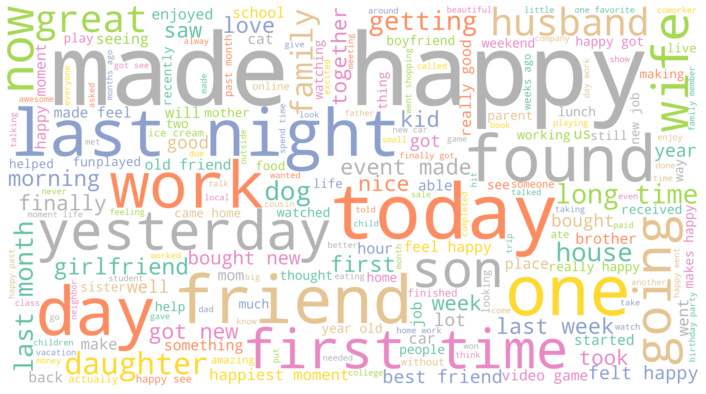

In [161]:
text = ' '.join(happy['cleaned_hm'].tolist())
wordcloud = WordCloud(background_color="white", height=2200, width=4000).generate(text)
plt.figure( figsize=(18,7) )
plt.imshow(wordcloud.recolor(colormap=plt.get_cmap('Set2')), interpolation='bilinear')
plt.axis("off")

**Text Preprocessing**

In [0]:
happy = pd.read_csv('cleaned_hm.csv')
happy=happy.head(5000) # Development/Testing: 5000
demographic = pd.read_csv('demographic_cleaned.csv')
#demographic = demographic[1:50000] #.sample(frac=0.1
# List of common words to remove, many thanks Chen-Chen for the initial inputs
nolist = ['happy', 'day', 'got', 'went', 'today', 'made', 'one', 'two', 'time', 'last', 'first', 'going',
'getting', 'took', 'found', 'lot', 'really', 'saw', 'see', 'month', 'week', 'day', 'yesterday',
'year', 'ago', 'now', 'still', 'since', 'something', 'great', 'good', 'long', 'thing', 'toi', 'without',
'yesteri', '2s', 'toand', 'ing', 'got', 'came', 'could', 'happiness', 'new', 'able', 'finally', 'like',
'old', 'years', 'many', '2', 'get', 'taj', 'nice', 'top', 'back']

happy = pd.merge(happy, demographic, on='wid')
happy.drop('age', axis=1, inplace=True)

#happy=happy[happy['age']<150] # Drop rows with age exceeding 150 years
#happy.loc[happy['age']<25,  'age'] = 0
#happy.loc[happy['age']>=25, 'age'] = 1

In [162]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)   
    # Now just remove any stopwords
    return [word for word in nopunc.split()
    if ((word.lower() not in stopwords) & (word.lower() not in nolist))]
# Apply to entire happy dataset, column cleaned_hm
happy['cleaned_hm'] = happy['cleaned_hm'].apply(text_process) #Sample of 10,000 rows
happy.head(1)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,"[successful, date, someone, felt, sympathy, co...",True,1,NaN,affection


In [0]:


# Convert list into string by joining words with a space
for i in range(0, len(happy)):
    happy['cleaned_hm'][i] = ' '.join(happy['cleaned_hm'][i])

(-0.5, 3999.5, 2199.5, -0.5)

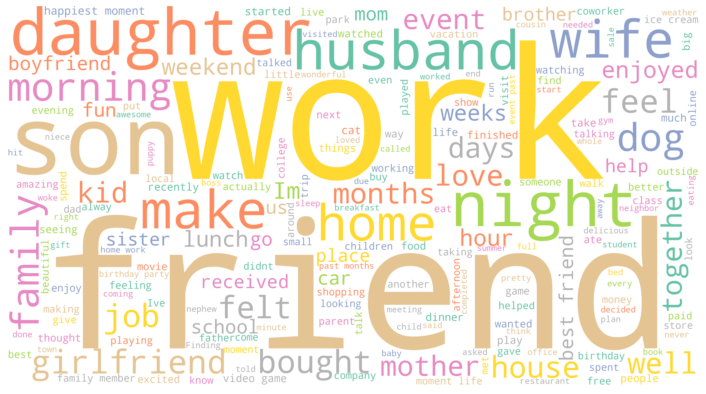

In [164]:
text = ' '.join(happy['cleaned_hm'].tolist())
wordcloud = WordCloud(background_color="white", height=2200, width=4000).generate(text)
plt.figure( figsize=(18,7) )
plt.imshow(wordcloud.recolor(colormap=plt.get_cmap('Set2')), interpolation='bilinear')
plt.axis("off")